### **2.4 Supervised Learning - Classification Models**
Steps:
1. Split the dataset into training (80%) and testing (20%) sets.
2. Train the following models:
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - Support Vector Machine (SVM)
3. Evaluate models using:
    - Accuracy, Precision, Recall, F1-score
    - ROC Curve & AUC Score

Deliverable:
Trained models with performance metrics

#### **Step 1: Train Models**

Initializing the models and splitting the data

In [91]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale only for Logistic Regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(
        C=0.01, solver="saga", penalty="l2", class_weight=None, max_iter=1000
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=None, min_samples_split=5, min_samples_leaf=2,
        criterion="gini", class_weight=None, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=8, min_samples_split=2,
        min_samples_leaf=2, max_features="log2", bootstrap=False,
        class_weight=None, random_state=42
    ),
    "SVM": SVC(
        C=1, kernel="rbf", gamma=0.1, probability=True,
        class_weight="balanced", random_state=42
    )
}

# Fit models (scaled for LR & SVM, raw for tree-based models)
fitted_models = {
    "Logistic Regression": models["Logistic Regression"].fit(X_train_scaled, y_train),
    "Decision Tree": models["Decision Tree"].fit(X_train, y_train),
    "Random Forest": models["Random Forest"].fit(X_train, y_train),
    "SVM": models["SVM"].fit(X_train_scaled, y_train),
}

#### **Step 2: Evaluate Models**

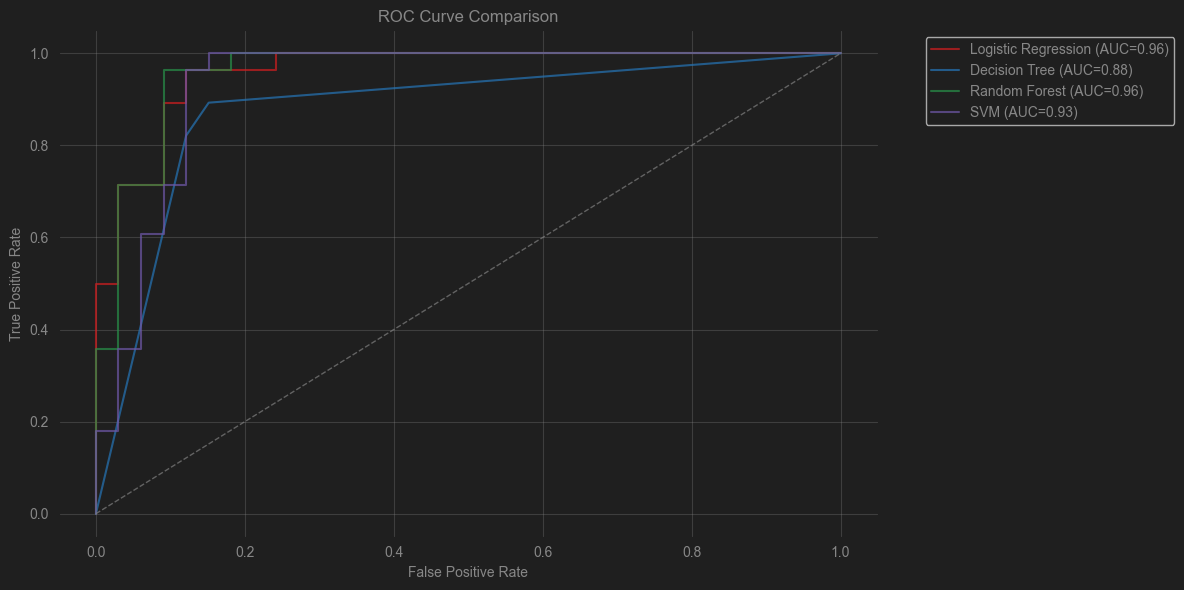

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.901639,0.866667,0.928571,0.896552,0.959957
1,Decision Tree,0.852459,0.851852,0.821429,0.836364,0.878788
2,Random Forest,0.934426,0.900000,0.964286,0.931034,0.959957
3,SVM,0.918033,0.870968,0.964286,0.915254,0.933983


In [92]:
# Color palette: one base color per model
palette = {
    "Logistic Regression": sns.color_palette("Reds", n_colors=10),
    "Decision Tree": sns.color_palette("Blues", n_colors=10),
    "Random Forest": sns.color_palette("Greens", n_colors=10),
    "SVM": sns.color_palette("Purples", n_colors=10),
}

results = []

plt.figure(figsize=(12,6))

for name, model in fitted_models.items():
    if name in ["Logistic Regression", "SVM"]:
        X_eval = X_test_scaled
    else:
        X_eval = X_test

    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)

    # Collect metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For binary classification, use probabilities for the positive class (index 1)
    auc = roc_auc_score(y_test, y_prob[:, 1])

    results.append([name, acc, prec, rec, f1, auc])

    # ROC curve for binary classification
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    plt.plot(fpr, tpr, 
             color=palette[name][7],
             alpha=0.7,
             label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1], color='gray', linestyle="--", linewidth=1, alpha=0.7)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-score","AUC"])
results_df

In [93]:
# Rank models by multiple metrics
results_df["Score"] = (
    0.25 * results_df["Accuracy"] +
    0.25 * results_df["Precision"] +
    0.25 * results_df["Recall"] +
    0.25 * results_df["F1-score"]
)

# Find the best model (by Score, or AUC)
best_row = results_df.sort_values(by=["Score", "AUC"], ascending=False).iloc[0]
best_model_name = best_row["Model"]

print(f"Best Model Selected: {best_model_name}")

Best Model Selected: Random Forest


##### **Confusion Matrices:**

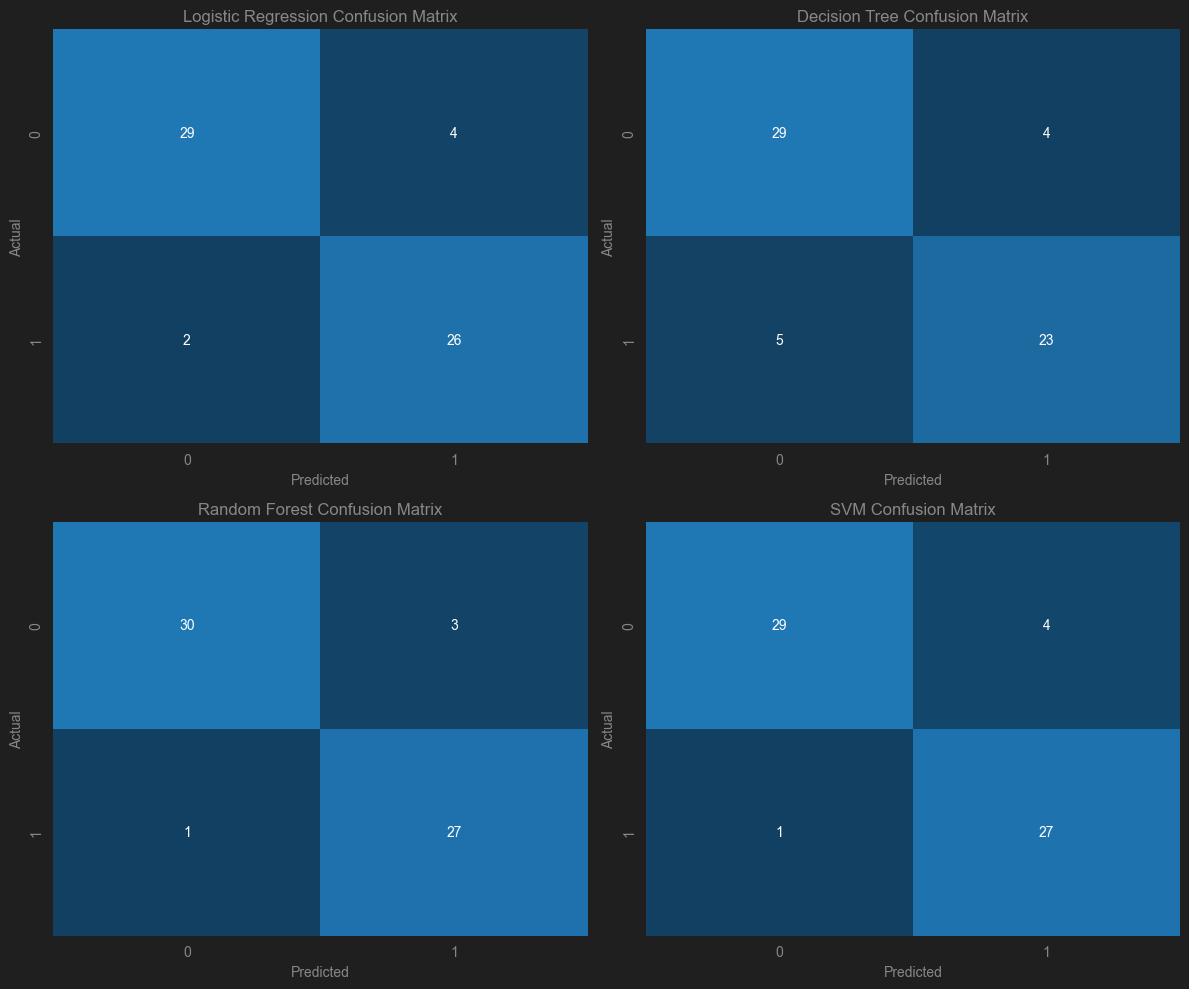

In [94]:
X_test_dict = {
    "Logistic Regression": X_test_scaled,
    "SVM": X_test_scaled,
    "Decision Tree": X_test,
    "Random Forest": X_test
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = [SECONDARY_COLOR, PRIMARY_COLOR]
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=256)

for idx, (name, model) in enumerate(fitted_models.items()):
    y_pred = model.predict(X_test_dict[name])
    
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap, cbar=False,
                ax=axes[idx], xticklabels=model.classes_, yticklabels=model.classes_)
    
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()
